# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [27]:
# -*- coding: utf-8 -*-
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [28]:

# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


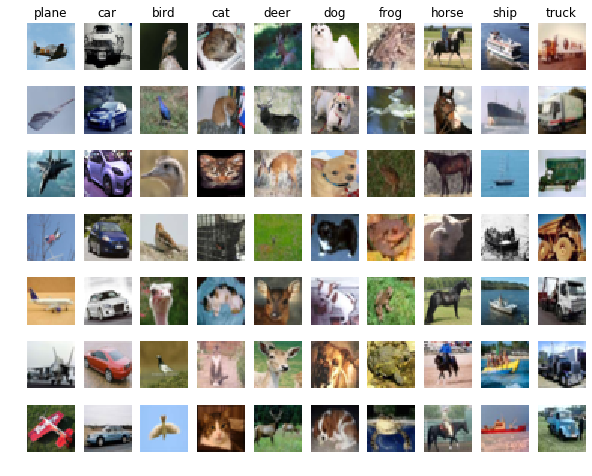

In [29]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)        # return non-zero element's indices
    idxs = np.random.choice(idxs, samples_per_class, replace=False)    # random pick from given array which is the indices
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [30]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print( 'Train labels shape: ', y_train.shape)
print( 'Validation data shape: ', X_val.shape)
print( 'Validation labels shape: ', y_val.shape)
print( 'Test data shape: ', X_test.shape)
print( 'Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [31]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


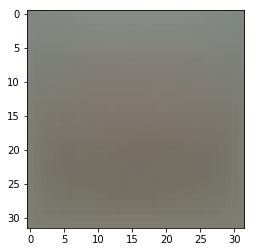

In [32]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [33]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [34]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [35]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('X_dev.shape:', X_dev.shape)
print('loss: %f' % (loss, ))
print('gard=', grad)
print('grad shape=', grad.shape)

X_dev.shape: (500, 3073)
loss: 8.461297
gard= [[  8.97121576  -8.21778335   7.48794628 ... -11.41989257 -23.36445837
  -43.92697404]
 [ -0.93861184  -5.4253151    7.19297714 ... -11.13595429 -30.40328776
  -46.1627853 ]
 [-21.60401779  -8.63987788  19.68053943 ... -15.60507886 -48.64269469
  -55.48340963]
 ...
 [  6.2744911    0.08606106 -12.31173029 ... -15.47053943  15.41515265
  -23.51970482]
 [ -8.65436743  -7.72323086  -2.357624   ...  -1.898752    -3.77607714
  -24.18232457]
 [  0.076       -0.072       -0.056      ...   0.112       -0.18
    0.176     ]]
grad shape= (3073, 10)


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [36]:
# http://cs231n.github.io/optimization-1/#analytic
# Strategy #1: A first very bad idea solution: Random search
bestloss = float("inf") # Python assigns the highest possible float value
for num in range(1000):
  W = np.random.randn(3073, 10) * 0.0001 # generate random parameters
  loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001) # get the loss over the entire training set
  if loss < bestloss: # keep track of the best solution
    bestloss = loss
    bestW = W
print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 999 the loss was 9.132109, best 8.146657


In [37]:
scores = X_test.dot(bestW)
# find the index with max score in each column (the predicted class)
Yte_predict = np.argmax(scores, axis = 1)
print(Yte_predict.shape)
# and calculate accuracy (fraction of predictions that are correct)
print(np.mean(Yte_predict == y_test))
# returns 0.1555

(1000,)
0.143


In [38]:
# Strategy #2: Random Local Search
W = np.random.randn(3073, 10) * 0.001 # generate random starting W
bestloss = float("inf")
for i in range(1000):
  step_size = 0.0001
  Wtry = W + np.random.randn(3073, 10) * step_size
  loss, grad = svm_loss_naive(Wtry, X_dev, y_dev, 0.00001)
  if loss < bestloss:
    W = Wtry
    bestloss = loss
  print('iter %d loss is %f' % (i, bestloss))

iter 0 loss is 21.342866
iter 1 loss is 21.342866
iter 2 loss is 21.296620
iter 3 loss is 21.296620
iter 4 loss is 21.240880
iter 5 loss is 21.240880
iter 6 loss is 21.143510
iter 7 loss is 21.143510
iter 8 loss is 21.076585
iter 9 loss is 20.896585
iter 10 loss is 20.896585
iter 11 loss is 20.501679
iter 12 loss is 20.501679
iter 13 loss is 20.501679
iter 14 loss is 20.501679
iter 15 loss is 20.388341
iter 16 loss is 20.388341
iter 17 loss is 20.325895
iter 18 loss is 20.325895
iter 19 loss is 20.272482
iter 20 loss is 20.272482
iter 21 loss is 20.088167
iter 22 loss is 19.992747
iter 23 loss is 19.992747
iter 24 loss is 19.992747
iter 25 loss is 19.992747
iter 26 loss is 19.862102
iter 27 loss is 19.862102
iter 28 loss is 19.862102
iter 29 loss is 19.862102
iter 30 loss is 19.862102
iter 31 loss is 19.828282
iter 32 loss is 19.828282
iter 33 loss is 19.828282
iter 34 loss is 19.828282
iter 35 loss is 19.828282
iter 36 loss is 19.442272
iter 37 loss is 19.442272
iter 38 loss is 19.442

iter 309 loss is 12.752151
iter 310 loss is 12.752151
iter 311 loss is 12.752151
iter 312 loss is 12.752151
iter 313 loss is 12.752151
iter 314 loss is 12.752151
iter 315 loss is 12.752151
iter 316 loss is 12.752151
iter 317 loss is 12.752151
iter 318 loss is 12.752151
iter 319 loss is 12.752151
iter 320 loss is 12.734408
iter 321 loss is 12.734408
iter 322 loss is 12.734408
iter 323 loss is 12.734408
iter 324 loss is 12.734408
iter 325 loss is 12.664007
iter 326 loss is 12.664007
iter 327 loss is 12.664007
iter 328 loss is 12.664007
iter 329 loss is 12.615634
iter 330 loss is 12.615634
iter 331 loss is 12.615634
iter 332 loss is 12.615634
iter 333 loss is 12.615634
iter 334 loss is 12.615634
iter 335 loss is 12.480967
iter 336 loss is 12.480967
iter 337 loss is 12.480967
iter 338 loss is 12.480967
iter 339 loss is 12.480967
iter 340 loss is 12.480967
iter 341 loss is 12.480967
iter 342 loss is 12.480967
iter 343 loss is 12.480967
iter 344 loss is 12.480967
iter 345 loss is 12.480967
i

iter 618 loss is 11.091250
iter 619 loss is 11.091250
iter 620 loss is 11.091250
iter 621 loss is 11.091250
iter 622 loss is 11.091250
iter 623 loss is 11.091250
iter 624 loss is 11.037064
iter 625 loss is 11.037064
iter 626 loss is 11.037064
iter 627 loss is 10.967124
iter 628 loss is 10.967124
iter 629 loss is 10.939583
iter 630 loss is 10.913592
iter 631 loss is 10.913592
iter 632 loss is 10.913592
iter 633 loss is 10.913592
iter 634 loss is 10.913592
iter 635 loss is 10.913592
iter 636 loss is 10.913592
iter 637 loss is 10.913592
iter 638 loss is 10.913592
iter 639 loss is 10.913592
iter 640 loss is 10.913592
iter 641 loss is 10.913592
iter 642 loss is 10.913592
iter 643 loss is 10.913592
iter 644 loss is 10.913592
iter 645 loss is 10.913592
iter 646 loss is 10.913592
iter 647 loss is 10.853346
iter 648 loss is 10.853346
iter 649 loss is 10.853346
iter 650 loss is 10.853346
iter 651 loss is 10.853346
iter 652 loss is 10.853346
iter 653 loss is 10.853346
iter 654 loss is 10.853346
i

iter 924 loss is 10.083508
iter 925 loss is 10.083508
iter 926 loss is 10.083508
iter 927 loss is 10.083508
iter 928 loss is 10.083508
iter 929 loss is 10.083508
iter 930 loss is 10.083508
iter 931 loss is 10.083508
iter 932 loss is 10.083508
iter 933 loss is 10.083508
iter 934 loss is 10.083508
iter 935 loss is 10.083508
iter 936 loss is 10.083508
iter 937 loss is 10.083508
iter 938 loss is 10.083508
iter 939 loss is 10.083508
iter 940 loss is 10.083508
iter 941 loss is 10.083508
iter 942 loss is 10.083508
iter 943 loss is 10.083508
iter 944 loss is 10.083508
iter 945 loss is 10.083508
iter 946 loss is 10.083508
iter 947 loss is 10.083508
iter 948 loss is 10.083508
iter 949 loss is 10.083508
iter 950 loss is 10.083508
iter 951 loss is 10.083508
iter 952 loss is 10.083508
iter 953 loss is 10.083508
iter 954 loss is 10.083508
iter 955 loss is 10.083508
iter 956 loss is 10.083508
iter 957 loss is 10.083508
iter 958 loss is 10.083508
iter 959 loss is 10.083508
iter 960 loss is 10.083508
i

In [39]:
scores = X_test.dot(bestW)
# find the index with max score in each column (the predicted class)
Yte_predict = np.argmax(scores, axis = 1)
print(Yte_predict.shape)
# and calculate accuracy (fraction of predictions that are correct)
print(np.mean(Yte_predict == y_test))
# returns 0.1555

(1000,)
0.143


### Strategy #3: Following the Gradient
Numerical gradient computation and weight update function

In [40]:
# Strategy #3: Following the Gradient
def eval_numerical_gradient(f, x):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros(x.shape)
    h = 1e-5
    
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        # evaluate function at x+h
        ix = it.multi_index
        old_value = x[ix]
        x[ix] = old_value + h    # increment by h
        fxh = f(x)    # evaluate f(x+h)
        x[ix] = old_value   # restore to previous value (very important!!!)
        
        # compute the partial derivative
        grad[ix] = (fxh - fx) / h
        it.iternext()
    return grad

In [41]:
def CIFAR10_loss_fun(W):
    x = X_test[0]
    y = y_test[0]
    loss = 0.0
    num_classes = W.shape[1]
    scores = x.dot(W)
    correct_class_score = scores[y]
    for j in range(num_classes):
        if j == y:
            continue
        margin = scores[j] - correct_class_score + 1
        if margin > 0:
            loss += margin
    loss += 0.5 * 1e-4 * np.sum(W*W)
    return loss

In [42]:

W = np.random.rand(3073, 10) * 1e-3
df = eval_numerical_gradient(CIFAR10_loss_fun, W)    # get the gradient
print('df shape:', df.shape)
print(df)
print(X_test[0])
loss_original = CIFAR10_loss_fun(W)
print('original loss: %f' % loss_original)

# lets see the effect of multiple step sizes
for step_size_log in range(-10, 0):
    step_size = 10 ** step_size_log
    W_new = W - step_size * df    # new position in the weight space
    loss_new = CIFAR10_loss_fun(W_new)
    print('for step size %0.10f new loss: %f' % (step_size, loss_new))

df shape: (3073, 10)
[[ 27.35810212  27.35810212  27.35810208 ...  27.3581021   27.35810211
   27.3581021 ]
 [-23.98173466 -23.98173463 -23.98173462 ... -23.98173469 -23.98173461
  -23.98173467]
 [-83.47391833 -83.47391833 -83.47391834 ... -83.47391837 -83.47391832
  -83.47391834]
 ...
 [-58.86195917 -58.86195916 -58.86195912 ... -58.86195914 -58.86195917
  -58.86195914]
 [ -4.39957142  -4.39957142  -4.39957135 ...  -4.39957141  -4.39957136
   -4.39957141]
 [  1.00000007   1.           1.00000002 ...   1.00000002   1.00000001
    1.00000005]]
[ 27.35810204 -23.98173469 -83.47391837 ... -58.86195918  -4.39957143
   1.        ]
original loss: 8.897500
for step size 0.0000000001 new loss: 8.841381
for step size 0.0000000010 new loss: 8.336314
for step size 0.0000000100 new loss: 3.766618
for step size 0.0000001000 new loss: 0.000001
for step size 0.0000010000 new loss: 0.000001
for step size 0.0000100000 new loss: 0.000003
for step size 0.0001000000 new loss: 0.000281
for step size 0.0010

In [43]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

print('====')
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e-2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e-2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 18.648073 analytic: 18.648073, relative error: 1.017153e-11
numerical: 36.045692 analytic: 36.045692, relative error: 8.593469e-12
numerical: 0.894162 analytic: 0.894162, relative error: 3.142839e-10
numerical: 17.449108 analytic: 17.449108, relative error: 1.587605e-12
numerical: -28.072653 analytic: -28.072653, relative error: 9.350018e-12
numerical: -30.388061 analytic: -30.388061, relative error: 2.334956e-12
numerical: 4.293475 analytic: 4.293475, relative error: 1.049964e-11
numerical: -15.615527 analytic: -15.615527, relative error: 2.891627e-11
numerical: -1.912899 analytic: -1.912899, relative error: 1.815383e-11
numerical: -18.067006 analytic: -18.067006, relative error: 1.546689e-11
====
numerical: 10.277875 analytic: 10.277875, relative error: 8.566904e-12
numerical: -3.324204 analytic: -3.324204, relative error: 8.769087e-11
numerical: 25.024437 analytic: 25.024437, relative error: 1.304979e-11
numerical: 3.387036 analytic: 3.387036, relative error: 1.451647e-10

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:**

SVM loss function uses $L_i = \displaystyle\sum_{j \neq y_i} max(0, W_j x_i - W_{y_i} x_i + 1)$ and its derivative is $\frac{\partial L_i}{\partial W_j} = \displaystyle\sum_{j \neq y_i} max(0, W_j)$ which implies cannot differentialable at 0. This cause gradient check fail when it comes to try about 0. 

In [44]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 1.003377e+01 computed in 0.068723s
Vectorized loss: 1.003377e+01 computed in 0.002105s
difference: -0.000000


In [45]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
loss_naive , grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('naive_loss:', loss_naive)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
loss_vectorized , grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
print('vectorized_loss:', loss_vectorized)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

print('loss difference=', loss_vectorized - loss_naive)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

naive_loss: 10.033768853979398
Naive loss and gradient: computed in 0.069426s
vectorized_loss: 10.033768853979426
Vectorized loss and gradient: computed in 0.002467s
loss difference= 2.842170943040401e-14
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [46]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 789.907027
iteration 100 / 1500: loss 287.784151
iteration 200 / 1500: loss 107.343274
iteration 300 / 1500: loss 42.471985
iteration 400 / 1500: loss 18.880620
iteration 500 / 1500: loss 10.664743
iteration 600 / 1500: loss 7.080213
iteration 700 / 1500: loss 6.321554
iteration 800 / 1500: loss 5.214988
iteration 900 / 1500: loss 5.392860
iteration 1000 / 1500: loss 5.850062
iteration 1100 / 1500: loss 5.392782
iteration 1200 / 1500: loss 5.109756
iteration 1300 / 1500: loss 5.308773
iteration 1400 / 1500: loss 5.360842
That took 3.511318s


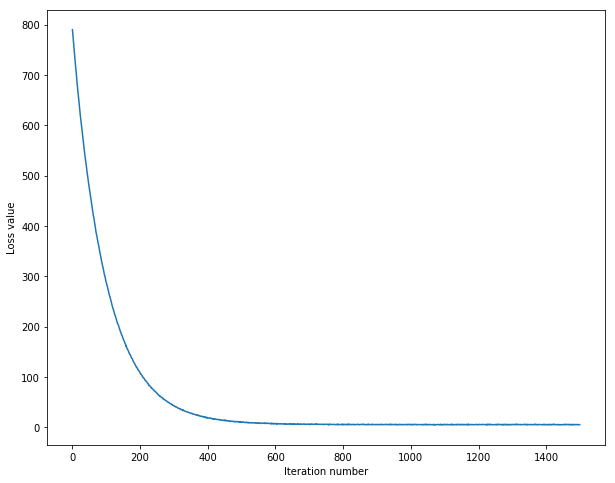

In [47]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [48]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367265
validation accuracy: 0.376000


In [49]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 1e-6, 1e-5, 5e-5]
regularization_strengths = [5e4, 1e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates: 
    for reg in regularization_strengths:
        loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4, num_iters=300, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 300: loss 5.098321
iteration 100 / 300: loss 5.655247
iteration 200 / 300: loss 5.565286
training accuracy: 0.370490
validation accuracy: 0.392000
iteration 0 / 300: loss 5.727641
iteration 100 / 300: loss 5.786302
iteration 200 / 300: loss 5.282637
training accuracy: 0.371347
validation accuracy: 0.366000
iteration 0 / 300: loss 5.245344
iteration 100 / 300: loss 5.648742
iteration 200 / 300: loss 5.131960
training accuracy: 0.364429
validation accuracy: 0.377000
iteration 0 / 300: loss 5.253620
iteration 100 / 300: loss 5.295181
iteration 200 / 300: loss 5.675489
training accuracy: 0.369776
validation accuracy: 0.374000
iteration 0 / 300: loss 5.553100
iteration 100 / 300: loss 4.745381
iteration 200 / 300: loss 5.621988
training accuracy: 0.369898
validation accuracy: 0.380000
iteration 0 / 300: loss 5.460275
iteration 100 / 300: loss 5.156251
iteration 200 / 300: loss 5.797223
training accuracy: 0.367694
validation accuracy: 0.369000
iteration 0 / 300: loss 4.737072
i

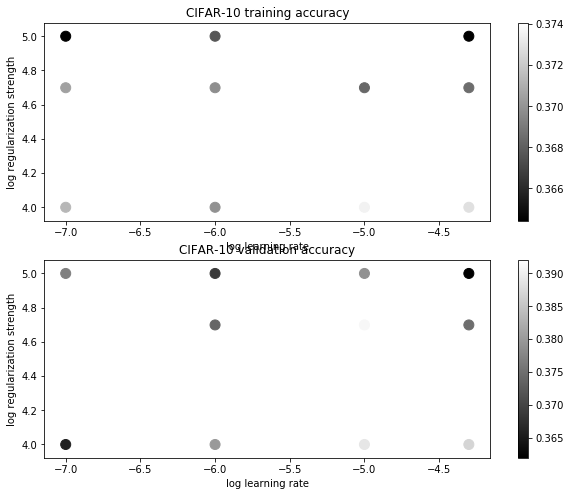

In [50]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [51]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.366000


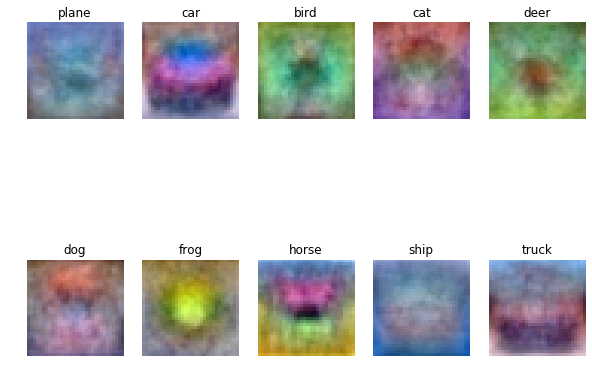

In [52]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:**

Weight vector looks likely to its answer class' template(mean of the class pictures), such as car weight vector looks like a car and so on. Since score is dot product of input and weight, the weight vector moves toward the answer class.